#Dep

In [ ]:
!pip install statsforecast

#Point forecast

Original rows: 541909
Rows after removing returns and zero price items: 530104
Capping Quantity at: 160.00

Rows before densification: 276148
Rows after densification: 1074653

Total series: 3922

Splitting data according to the paper's 'Fixed Origin' method...
After filtering series shorter than 30 days, 3649 series remain.
Initial Set Shape: (356291, 5)
Evaluation Set Shape: (716717, 5)
Optimizer successful: alpha_hat=0.9820, beta_hat=2.8333
Log-Normal Global Mean: 1.4816, Pooled Variance: 1.0812

Calculating naive error for RMSSE denominator...
Calculated RMSSE denominators for 3649 series.


/tmp/ipython-input-103760740.py:191: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  eval_set_merged['TSB-HB-LogNormal'].fillna(0, inplace=True)


Evaluating model: index
Evaluating model: CrostonClassic
Evaluating model: CrostonSBA
Evaluating model: TSB
Evaluating model: ADIDA
Evaluating model: IMAPA
Evaluating model: Theta
Evaluating model: ARIMA
Evaluating model: TSB-HB-LogNormal

=== Online Retail Results (Paper's Fixed Origin Method) ===
              model          ME         MAE        RMSE       RMSSE
8  TSB-HB-LogNormal   -1.099343    5.518985   17.805409    4.789259
7             ARIMA   -0.624375    5.751487   17.707805    4.790956
4             ADIDA   -0.760293    5.686042   17.961724    4.796685
5             IMAPA   -0.759879    5.700035   17.996252    4.796959
3               TSB   -1.625463    5.578295   18.812509    4.804101
6             Theta   -1.515228    7.167489   20.080396    4.840408
2        CrostonSBA   -0.046753    6.195270   18.163275    5.069245
1    CrostonClassic    0.201045    6.329356   18.231957    5.105116
0             index  105.727392  107.292894  127.648991  230.585243

Generating shrinkag

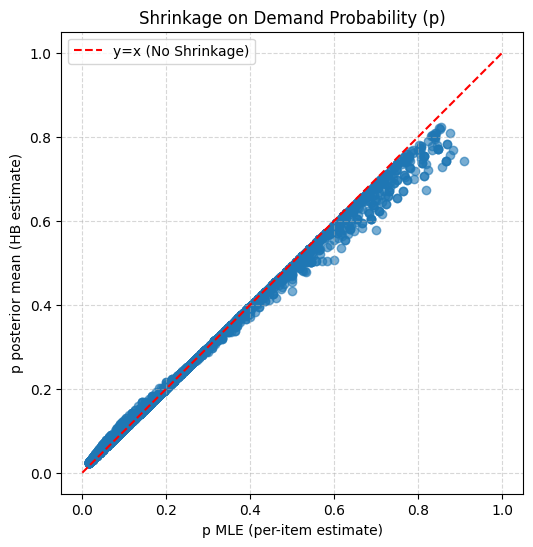

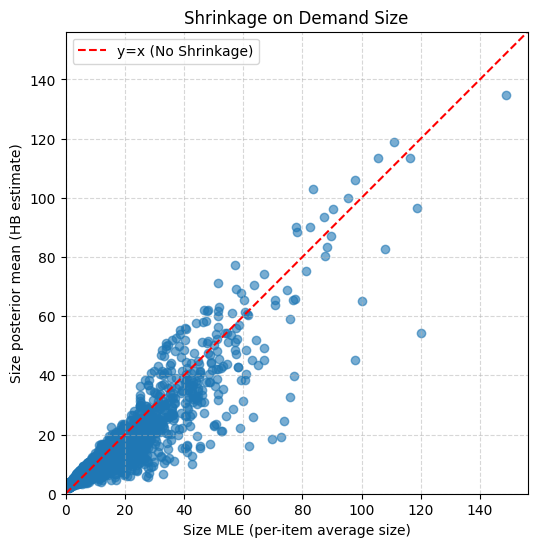

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.optimize as opt
from statsforecast import StatsForecast
from statsforecast.models import CrostonClassic, CrostonSBA, TSB, ADIDA, IMAPA, ARIMA, Theta

# -------------------
# 0) Load + Preprocess (Unchanged)
# -------------------
# You might need to adjust the file path
FILE = "/content/drive/MyDrive/AISTATS2026/Online_Retail.csv"
df_raw = pd.read_csv(FILE, encoding="latin1")

# Keep only needed columns
df = df_raw[["InvoiceDate", "StockCode", "Quantity", "UnitPrice"]].copy()

# Explicitly handle returns (negative Quantity) and zero price items by removing them.
print(f"Original rows: {len(df)}")
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)].copy()
print(f"Rows after removing returns and zero price items: {len(df)}")

# Capping outliers in Quantity
q_cap = df['Quantity'].quantile(0.995)
print(f"Capping Quantity at: {q_cap:.2f}")
df['Quantity'] = df['Quantity'].clip(upper=q_cap)

# Convert InvoiceDate to datetime, aggregate to daily sales per StockCode
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["ds"] = df["InvoiceDate"].dt.date
df = df.groupby(["StockCode", "ds"], as_index=False)["Quantity"].sum()

# Rename for StatsForecast
df = df.rename(columns={"StockCode":"unique_id", "Quantity":"y"})
df["ds"] = pd.to_datetime(df["ds"])

# Fill in missing dates to create a dense time series for each unique_id.
print(f"\nRows before densification: {len(df)}")
df = df.set_index('ds').groupby('unique_id')['y'].apply(
    lambda x: x.asfreq('D', fill_value=0)
).reset_index()
print(f"Rows after densification: {len(df)}")

print("\nTotal series:", df["unique_id"].nunique())
df = df.sort_values(["unique_id", "ds"])

# -------------------
# 1) [MODIFIED] Train/Test split based on the Paper's Method
# -------------------
print("\nSplitting data according to the paper's 'Fixed Origin' method...")

# Define the ratio for the initial set, as per the paper (1/3 for init, 2/3 for eval)
INIT_RATIO = 1/3
MIN_LEN = 30 # Set a minimum length for a series to be included

# Calculate a time index 't' and the total length 'L' for each series
df['t'] = df.groupby('unique_id').cumcount()
df['L'] = df.groupby('unique_id')['t'].transform('max') + 1

# Filter out series that are too short
df = df[df['L'] >= MIN_LEN].copy()
print(f"After filtering series shorter than {MIN_LEN} days, {df['unique_id'].nunique()} series remain.")

# Split into an initial set (for training) and an evaluation set (for testing)
init_set = df[df['t'] < np.floor(df['L'] * INIT_RATIO)].copy()
eval_set = df[df['t'] >= np.floor(df['L'] * INIT_RATIO)].copy()

valid_ids = df['unique_id'].unique()
print(f"Initial Set Shape: {init_set.shape}")
print(f"Evaluation Set Shape: {eval_set.shape}")

# -------------------
# 2) [ADAPTED] TSB-HB Model trained on the Initial Set
# -------------------
# The TSB-HB model logic remains the same, but it's now trained only on the initial data period.
init_set["occ"] = (init_set["y"] > 0).astype(int)
init_set["size"] = np.where(init_set["occ"]==1, init_set["y"].astype(float), np.nan)
init_set["log_size"] = np.log(init_set["size"])

# --- Part A: Demand Probability ---
g_init = init_set.groupby("unique_id")
s = g_init["occ"].sum()
n = g_init["ds"].nunique()

def beta_binom_log_marginal(s:int, n:int, alpha:float, beta:float)->float:
    if alpha <= 0 or beta <= 0 or s < 0 or n < s: return -np.inf
    return (
        math.lgamma(n + 1) - math.lgamma(s + 1) - math.lgamma(n - s + 1) +
        math.lgamma(s + alpha) + math.lgamma(n - s + beta) - math.lgamma(n + alpha + beta) -
        (math.lgamma(alpha) + math.lgamma(beta) - math.lgamma(alpha + beta))
    )

def estimate_beta_hyperparams(counts: pd.DataFrame):
    s_arr, n_arr = counts["s"].astype(int).values, counts["n"].astype(int).values
    valid_indices = (n_arr > 0) & (s_arr <= n_arr)
    s_arr, n_arr = s_arr[valid_indices], n_arr[valid_indices]
    def objective_fn(params):
        alpha, beta = params
        if alpha <= 0 or beta <= 0: return np.inf
        log_likelihoods = [beta_binom_log_marginal(si, ni, alpha, beta) for si, ni in zip(s_arr, n_arr)]
        return -sum(log_likelihoods)
    initial_guess = [1.0, 10.0]
    bounds = [(1e-6, None), (1e-6, None)]
    result = opt.minimize(fun=objective_fn, x0=initial_guess, method='L-BFGS-B', bounds=bounds)
    if result.success:
        best_alpha, best_beta = result.x
        print(f"Optimizer successful: alpha_hat={best_alpha:.4f}, beta_hat={best_beta:.4f}")
        return float(best_alpha), float(best_beta)
    else:
        print("Optimizer failed, returning default values.")
        return 1.0, 1.0

alpha_hat, beta_hat = estimate_beta_hyperparams(pd.DataFrame({"s": s, "n": n}))
p_post_mean = (alpha_hat + s) / (alpha_hat + beta_hat + n)

# --- Part B: Demand Size ---
def estimate_log_normal_posterior_mean(df_init):
    item_stats = df_init.groupby('unique_id')['log_size'].agg(
        n_pos='count', mean_log='mean', var_log='var'
    ).reset_index()
    item_stats = item_stats[item_stats['n_pos'] > 1].copy()
    if item_stats.empty: return pd.Series()
    global_mean = np.mean(item_stats['mean_log'])
    pooled_var = np.mean(item_stats['var_log'])
    k = pooled_var / np.var(item_stats['mean_log']) if np.var(item_stats['mean_log']) > 0 else 10
    item_stats['credibility'] = item_stats['n_pos'] / (item_stats['n_pos'] + k)
    item_stats['shrunk_mean_log'] = (item_stats['credibility'] * item_stats['mean_log']) + \
                                     ((1 - item_stats['credibility']) * global_mean)
    item_stats['pred_size'] = np.exp(item_stats['shrunk_mean_log'] + (pooled_var / 2))
    print(f"Log-Normal Global Mean: {global_mean:.4f}, Pooled Variance: {pooled_var:.4f}")
    return item_stats.set_index('unique_id')['pred_size']

size_pred_mean = estimate_log_normal_posterior_mean(init_set)
mean_pred_hb = (p_post_mean * size_pred_mean).fillna(0)

# -------------------
# 3) [ADAPTED] Baselines trained on the Initial Set
# -------------------
sf = StatsForecast(
    models=[CrostonClassic(), CrostonSBA(), TSB(alpha_d=0.5, alpha_p=0.5), ADIDA(), IMAPA(),Theta(),ARIMA()],
    freq='D', n_jobs=-1
)

# Fit on the initial set and forecast for the length of the evaluation set
# Note: This can be slow as it loops through each series.
all_forecasts = []
eval_set_lengths = eval_set['unique_id'].value_counts()

# Using a loop is necessary here for variable forecast horizons (h)
for uid in valid_ids:
    h = eval_set_lengths.get(uid, 0)
    if h > 0:
        # Fit on the initial data for this specific series
        uid_init_df = init_set[init_set['unique_id'] == uid][['unique_id', 'ds', 'y']]
        if not uid_init_df.empty:
            sf.fit(df=uid_init_df)
            forecast = sf.predict(h=h)
            all_forecasts.append(forecast)

fcst_df = pd.concat(all_forecasts).reset_index()

# -------------------
# 4) [MODIFIED & ENHANCED] Evaluation on the Evaluation Set with ME, MAE, RMSE, RMSSE
# -------------------
def my_me(y, yhat): return float(np.nanmean(yhat - y))
def my_mae(y, yhat): return float(np.nanmean(np.abs(yhat - y)))
def my_rmse(y, yhat): return float(np.sqrt(np.nanmean((yhat - y)**2)))

# --- Step 4.1: Calculate the denominator for RMSSE ---
# This is the mean squared error of a naive (lag-1) forecast on the training set.
print("\nCalculating naive error for RMSSE denominator...")
init_set_sorted = init_set.sort_values(['unique_id', 'ds'])
init_set_sorted['y_lag1'] = init_set_sorted.groupby('unique_id')['y'].shift(1)
init_set_sorted['naive_sq_err'] = (init_set_sorted['y'] - init_set_sorted['y_lag1'])**2
# Use a small epsilon to avoid division by zero for series with zero variance
epsilon = 1e-9
rmsse_denominators = init_set_sorted.groupby('unique_id')['naive_sq_err'].mean()
rmsse_denominators = rmsse_denominators.where(rmsse_denominators > 0, epsilon)
print(f"Calculated RMSSE denominators for {len(rmsse_denominators)} series.")


# --- Step 4.2: Merge all forecasts with actual values ---
eval_set_merged = eval_set[['unique_id', 'ds', 'y']].copy()
eval_set_merged = eval_set_merged.merge(fcst_df, on=['unique_id', 'ds'], how='left')
eval_set_merged = eval_set_merged.merge(
    mean_pred_hb.rename('TSB-HB-LogNormal'),
    on='unique_id',
    how='left'
)
eval_set_merged['TSB-HB-LogNormal'].fillna(0, inplace=True)

# --- Step 4.3: Calculate Metrics for each model ---
results = []
models_to_eval = [col for col in eval_set_merged.columns if col not in ['unique_id', 'ds', 'y']]

for model in models_to_eval:
    print(f"Evaluating model: {model}")

    # Create a temporary df for this model's evaluation
    temp_df = eval_set_merged[['unique_id', 'y', model]].copy()
    temp_df.rename(columns={model: 'y_pred'}, inplace=True)
    temp_df.dropna(subset=['y_pred'], inplace=True)

    # --- Global metrics (ME, MAE, RMSE) ---
    y_true_all = temp_df['y'].values
    y_pred_all = temp_df['y_pred'].values

    me_val = my_me(y_true_all, y_pred_all)
    mae_val = my_mae(y_true_all, y_pred_all)
    rmse_val = my_rmse(y_true_all, y_pred_all)

    # --- RMSSE Calculation (per series, then averaged) ---
    temp_df = temp_df.merge(rmsse_denominators.rename('rmsse_denom'), on='unique_id', how='left')
    temp_df['model_sq_err'] = (temp_df['y'] - temp_df['y_pred'])**2
    mse_per_series = temp_df.groupby('unique_id')['model_sq_err'].mean()

    # Merge back to get the denominator for each series
    series_eval = pd.concat([mse_per_series.rename('model_mse'),
                             temp_df.groupby('unique_id')['rmsse_denom'].first()], axis=1)

    # Calculate scaled error for each series
    series_eval['scaled_err_sq'] = series_eval['model_mse'] / series_eval['rmsse_denom']

    # Final RMSSE is the root of the mean of scaled squared errors
    rmsse_val = np.sqrt(np.nanmean(series_eval['scaled_err_sq']))

    results.append({
        "model": model,
        "ME": me_val,
        "MAE": mae_val,
        "RMSE": rmse_val,
        "RMSSE": rmsse_val
    })

results_df = pd.DataFrame(results)
print("\n=== Online Retail Results (Paper's Fixed Origin Method) ===")
# Display results sorted by RMSSE, as it's a robust metric for this task
print(results_df.sort_values("RMSSE"))


# --- Plotting section (unchanged) ---
print("\nGenerating shrinkage plots...")

# Data Preparation for Plots
p_mle = s / n
size_mle = g_init['size'].mean()
plot_df = pd.DataFrame({
    'p_mle': p_mle,
    'p_posterior': p_post_mean,
    'size_mle': size_mle,
    'size_posterior': size_pred_mean
}).dropna()

# Plot 1: Shrinkage on p
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(plot_df['p_mle'], plot_df['p_posterior'], alpha=0.6)
ax.plot([0, 1], [0, 1], 'r--', label='y=x (No Shrinkage)')
ax.set_xlabel('p MLE (per-item estimate)')
ax.set_ylabel('p posterior mean (HB estimate)')
ax.set_title('Shrinkage on Demand Probability (p)')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_aspect('equal', adjustable='box')
ax.legend()
plt.show()

# Plot 2: Shrinkage on Size
lim_max = max(plot_df['size_mle'].max(), plot_df['size_posterior'].max()) * 1.05
lim_min = 0
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(plot_df['size_mle'], plot_df['size_posterior'], alpha=0.6)
ax.plot([lim_min, lim_max], [lim_min, lim_max], 'r--', label='y=x (No Shrinkage)')
ax.set_xlabel('Size MLE (per-item average size)')
ax.set_ylabel('Size posterior mean (HB estimate)')
ax.set_title('Shrinkage on Demand Size')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xlim(lim_min, lim_max)
ax.set_ylim(lim_min, lim_max)
ax.set_aspect('equal', adjustable='box')
ax.legend()
plt.show()

#Performance Segmentation Analysis

In [ ]:
# ==============================================================================
# 實驗一：性能細分分析 (Performance Segmentation Analysis)
# ==============================================================================
# 假設前一個程式碼區塊中的以下變數已經存在且可被存取：
# - init_set, eval_set_merged (資料)
# - n, s (用於計算 ADI)
# - my_me, my_mae, my_rmse (指標函數)
# - rmsse_denominators (RMSSE 計算所需的分母)
# ==============================================================================

print("\nRunning Experiment 1: Performance Segmentation Analysis...")

# --- Step 1: Calculate ADI and CV² for each series from the initial set ---
print("Step 1/4: Calculating ADI and CV² for each series...")

# For CV², we only consider periods with actual demand
demand_events = init_set[init_set['y'] > 0]
series_stats = demand_events.groupby('unique_id')['y'].agg(['mean', 'std']).reset_index()
series_stats['cv_sq'] = (series_stats['std'] / series_stats['mean']) ** 2
series_stats['cv_sq'].fillna(0, inplace=True) # If std is NaN (e.g., only one sale), CV² is 0

# For ADI, we use the counts 's' (demand occurrences) and 'n' (total period length)
# from the previous section. This is the most accurate way.
adi_df = pd.DataFrame({
    'n': n,
    's': s
}).reset_index()

# Avoid division by zero for series that might have had no sales in the init set
adi_df['adi'] = np.where(adi_df['s'] > 0, adi_df['n'] / adi_df['s'], adi_df['n'])

# Combine into a single characteristics dataframe
series_characteristics = pd.merge(series_stats[['unique_id', 'cv_sq']], adi_df[['unique_id', 'adi']], on='unique_id')

# --- Step 2: Classify series into four categories ---
print("Step 2/4: Classifying series into categories...")

def classify_series(row):
    adi_threshold = 1.32
    cv2_threshold = 0.49
    if row['adi'] <= adi_threshold and row['cv_sq'] <= cv2_threshold:
        return 'Smooth'
    elif row['adi'] > adi_threshold and row['cv_sq'] <= cv2_threshold:
        return 'Intermittent'
    elif row['adi'] <= adi_threshold and row['cv_sq'] > cv2_threshold:
        return 'Erratic'
    else: # adi > adi_threshold and cv_sq > cv2_threshold
        return 'Lumpy'

series_characteristics['category'] = series_characteristics.apply(classify_series, axis=1)
category_counts = series_characteristics['category'].value_counts()
print("\nSeries counts per category:")
print(category_counts)

# --- Step 3: Merge categories into the main evaluation results ---
print("\nStep 3/4: Merging categories with evaluation results...")

eval_with_cats = pd.merge(eval_set_merged, series_characteristics[['unique_id', 'category']], on='unique_id', how='left')

# --- Step 4: Calculate metrics for each segment and display results ---
print("Step 4/4: Calculating and displaying segmented metrics...")

segmented_results = []
models_to_eval = [col for col in eval_with_cats.columns if col not in ['unique_id', 'ds', 'y', 'category']]
categories = sorted([cat for cat in eval_with_cats['category'].unique() if pd.notna(cat)])

for category in categories:
    subset_df = eval_with_cats[eval_with_cats['category'] == category]

    for model in models_to_eval:
        # Create a temporary df for this specific model and category
        temp_df = subset_df[['unique_id', 'y', model]].copy()
        temp_df.rename(columns={model: 'y_pred'}, inplace=True)
        temp_df.dropna(subset=['y_pred'], inplace=True)

        # --- Calculate ME, MAE, RMSE (Global for the category) ---
        y_true_cat = temp_df['y'].values
        y_pred_cat = temp_df['y_pred'].values

        me_val = my_me(y_true_cat, y_pred_cat)
        mae_val = my_mae(y_true_cat, y_pred_cat)
        rmse_val = my_rmse(y_true_cat, y_pred_cat)

        # --- Calculate RMSSE (Per-series within the category) ---
        temp_df = temp_df.merge(rmsse_denominators.rename('rmsse_denom'), on='unique_id', how='left')
        temp_df['model_sq_err'] = (temp_df['y'] - temp_df['y_pred'])**2
        mse_per_series_cat = temp_df.groupby('unique_id')['model_sq_err'].mean()
        denom_per_series_cat = temp_df.groupby('unique_id')['rmsse_denom'].first()
        scaled_error_sq_cat = mse_per_series_cat / denom_per_series_cat
        rmsse_val = np.sqrt(np.nanmean(scaled_error_sq_cat))

        segmented_results.append({
            'category': category,
            'model': model,
            'ME': me_val,
            'MAE': mae_val,
            'RMSE': rmse_val,
            'RMSSE': rmsse_val
        })

segmented_results_df = pd.DataFrame(segmented_results)

# --- Display Results in Pivoted Tables for Easy Comparison ---
print("\n\n" + "="*55)
print("      PERFORMANCE SEGMENTATION RESULTS (FULL METRICS)")
print("="*55)

# Order categories for logical presentation
category_order = ['Smooth', 'Erratic', 'Intermittent', 'Lumpy']
category_order_present = [c for c in category_order if c in segmented_results_df['category'].unique()]

# ME Results
me_pivot = segmented_results_df.pivot(index='model', columns='category', values='ME')[category_order_present]
print("\n--- ME (Mean Error) by Demand Category ---")
print(me_pivot.round(4))

# MAE Results
mae_pivot = segmented_results_df.pivot(index='model', columns='category', values='MAE')[category_order_present]
print("\n--- MAE (Mean Absolute Error) by Demand Category ---")
print(mae_pivot.round(4))

# RMSE Results
rmse_pivot = segmented_results_df.pivot(index='model', columns='category', values='RMSE')[category_order_present]
print("\n--- RMSE (Root Mean Squared Error) by Demand Category ---")
print(rmse_pivot.round(4))

# RMSSE Results
rmsse_pivot = segmented_results_df.pivot(index='model', columns='category', values='RMSSE')[category_order_present]
print("\n--- RMSSE (Root Mean Squared Scaled Error) by Demand Category ---")
print(rmsse_pivot.round(4))
print("\n" + "="*55)


Running Experiment 1: Performance Segmentation Analysis...
Step 1/4: Calculating ADI and CV² for each series...
Step 2/4: Classifying series into categories...

Series counts per category:
category
Lumpy           2524
Intermittent    1041
Erratic           75
Smooth             9
Name: count, dtype: int64

Step 3/4: Merging categories with evaluation results...
Step 4/4: Calculating and displaying segmented metrics...


/tmp/ipython-input-12923793.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  series_stats['cv_sq'].fillna(0, inplace=True) # If std is NaN (e.g., only one sale), CV² is 0




      PERFORMANCE SEGMENTATION RESULTS (FULL METRICS)

--- ME (Mean Error) by Demand Category ---
category           Smooth  Erratic  Intermittent     Lumpy
model                                                     
ADIDA              1.2140  -3.4233       -0.5477   -0.7922
ARIMA              4.5172   1.8018       -0.4558   -0.7229
CrostonClassic     4.6784  -1.2778        0.7624    0.0318
CrostonSBA         3.5826  -2.9120        0.6695   -0.2458
IMAPA              1.2140  -3.4233       -0.5547   -0.7893
TSB                3.6530  -4.8297       -0.5724   -1.9335
TSB-HB-LogNormal   5.6746   0.1482       -0.2183   -1.4199
Theta             -0.5171 -13.5271       -0.7865   -1.5748
index             11.0209  40.4057      100.9274  108.4294

--- MAE (Mean Absolute Error) by Demand Category ---
category           Smooth  Erratic  Intermittent     Lumpy
model                                                     
ADIDA             15.4399  30.3260        1.3098    6.7629
ARIMA             15

#Ablation Study

In [ ]:
# ==============================================================================
# 實驗二：模型消融研究 (Ablation Study)
# ==============================================================================
# 假設前一個程式碼區塊中的以下變數已經存在且可被存取：
# - init_set, eval_set_merged (資料)
# - g_init, s, n, p_post_mean (HB 模型相關統計量)
# - my_me, my_mae, my_rmse (指標函數)
# - rmsse_denominators (RMSSE 計算所需的分母)
# ==============================================================================

print("\nRunning Experiment 2: Ablation Study...")

# --- Step 1: Create the "Ablated" Models ---
print("Step 1/3: Building the ablated model versions...")

# --- Ablation Model A: TSB-MLE-LogNormal (Ablating the "HB" component) ---
# This model uses the LogNormal assumption but without hierarchical shrinkage.
# It relies purely on each item's own data (Maximum Likelihood Estimate).

# A1. Get p_mle
p_mle = s / n

# A2. Get size_mle based on the LogNormal mean formula
item_stats_for_mle = init_set.groupby('unique_id')['log_size'].agg(
    mean_log='mean', var_log='var'
).fillna(0) # Use 0 for var if only one data point

# The MLE of the LogNormal mean is exp(mu_mle + sigma_mle^2 / 2)
item_stats_for_mle['size_mle_lognormal'] = np.exp(
    item_stats_for_mle['mean_log'] + (item_stats_for_mle['var_log'] / 2)
)

# A3. Combine to get the final forecast
forecast_mle = (p_mle * item_stats_for_mle['size_mle_lognormal']).fillna(0)
print("  - TSB-MLE-LogNormal forecast created.")


# --- Ablation Model B: TSB-HB-Gamma (Ablating the "LogNormal" component) ---
# This model uses the Hierarchical Bayesian framework but reverts to the Gamma distribution.

# B1. Calculate necessary stats for the Gamma model
S_pos = g_init["size"].sum()
n_pos = g_init["occ"].sum() # Note: This is different from `s` which is a Series
lambda_mle = n_pos / S_pos

# B2. Re-implement the Gamma hyperparameter estimation
def estimate_gamma_hyperparams(lambda_hats: pd.Series):
    lam = lambda_hats.dropna()
    lam = lam[np.isfinite(lam) & (lam > 0)]
    if lam.empty: return 1.0, 1.0
    m, v = lam.mean(), lam.var()
    v = max(v, 1e-6) # Ensure variance is positive
    a, b = m*m/v, m/v
    return float(max(a, 1e-3)), float(max(b, 1e-6))

a_hat, b_hat = estimate_gamma_hyperparams(lambda_mle)
print(f"  - Gamma Hyperpriors Estimated: a_hat={a_hat:.4f}, b_hat={b_hat:.4f}")

# B3. Calculate posterior predictive mean size for the Gamma model
c = a_hat + n_pos
d = b_hat + S_pos
# The posterior predictive mean E[size] is d / (c - 1) for the Gamma-Poisson model
size_posterior_gamma = d / (c - 1)

# B4. Combine with the original p_posterior to get the final forecast
forecast_gamma = (p_post_mean * size_posterior_gamma).fillna(0)
print("  - TSB-HB-Gamma forecast created.")


# --- Step 2: Merge Ablated Forecasts into the Evaluation Set ---
print("Step 2/3: Merging ablated forecasts for evaluation...")

# Start with the evaluation dataframe we already have
ablation_eval_df = eval_set_merged.copy()

# Add the two new models' forecasts
ablation_eval_df = ablation_eval_df.merge(
    forecast_mle.rename('TSB-MLE-LogNormal'), on='unique_id', how='left'
)
ablation_eval_df['TSB-MLE-LogNormal'] = ablation_eval_df['TSB-MLE-LogNormal'].fillna(0)

ablation_eval_df = ablation_eval_df.merge(
    forecast_gamma.rename('TSB-HB-Gamma'), on='unique_id', how='left'
)
ablation_eval_df['TSB-HB-Gamma'] = ablation_eval_df['TSB-HB-Gamma'].fillna(0)


# --- Step 3: Calculate Metrics and Display Full Results Table ---
print("Step 3/3: Calculating and displaying ablation study results...")

ablation_results = []
models_for_ablation = [col for col in ablation_eval_df.columns if col not in ['unique_id', 'ds', 'y']]

for model in models_for_ablation:
    # Create a temporary df for this model's evaluation
    temp_df = ablation_eval_df[['unique_id', 'y', model]].copy()
    temp_df.rename(columns={model: 'y_pred'}, inplace=True)
    temp_df.dropna(subset=['y_pred'], inplace=True)

    # --- Global metrics (ME, MAE, RMSE) ---
    y_true_all = temp_df['y'].values
    y_pred_all = temp_df['y_pred'].values

    me_val = my_me(y_true_all, y_pred_all)
    mae_val = my_mae(y_true_all, y_pred_all)
    rmse_val = my_rmse(y_true_all, y_pred_all)

    # --- RMSSE Calculation (per series) ---
    temp_df = temp_df.merge(rmsse_denominators.rename('rmsse_denom'), on='unique_id', how='left')
    temp_df['model_sq_err'] = (temp_df['y'] - temp_df['y_pred'])**2
    mse_per_series = temp_df.groupby('unique_id')['model_sq_err'].mean()
    scaled_error_sq = mse_per_series / temp_df.groupby('unique_id')['rmsse_denom'].first()
    rmsse_val = np.sqrt(np.nanmean(scaled_error_sq))

    ablation_results.append({
        "model": model,
        "ME": me_val,
        "MAE": mae_val,
        "RMSE": rmse_val,
        "RMSSE": rmsse_val
    })

ablation_results_df = pd.DataFrame(ablation_results)

# Sort by RMSSE to easily see the hierarchy of performance
ablation_results_df = ablation_results_df.sort_values("RMSSE").set_index('model')

print("\n\n" + "="*60)
print("                 ABLATION STUDY RESULTS (FULL METRICS)")
print("="*60)
print(ablation_results_df.round(4))
print("\n" + "="*60)


Running Experiment 2: Ablation Study...
Step 1/3: Building the ablated model versions...
  - TSB-MLE-LogNormal forecast created.
  - Gamma Hyperpriors Estimated: a_hat=0.8803, b_hat=3.2845
  - TSB-HB-Gamma forecast created.
Step 2/3: Merging ablated forecasts for evaluation...
Step 3/3: Calculating and displaying ablation study results...


                 ABLATION STUDY RESULTS (FULL METRICS)
                         ME       MAE      RMSE     RMSSE
model                                                    
TSB-HB-Gamma        -0.6220    5.7721   17.7017    4.7860
TSB-HB-LogNormal    -1.0993    5.5190   17.8054    4.7893
TSB-MLE-LogNormal   -0.1145    5.9931   17.7577    4.7912
ADIDA               -0.7603    5.6860   17.9617    4.7967
IMAPA               -0.7599    5.7000   17.9963    4.7970
TSB                 -1.6255    5.5783   18.8125    4.8041
CrostonSBA          -0.0468    6.1953   18.1633    5.0692
CrostonClassic       0.2010    6.3294   18.2320    5.1051
index              10

In [ ]:
# ==============================================================================
# 實驗五：基線模型參數敏感度分析 (Hyperparameter Sensitivity Analysis)
# ==============================================================================

print("\nRunning Experiment 5: Hyperparameter Sensitivity Analysis for TSB Baseline...")

# --- Step 1: Define the Hyperparameter Grid ---
# Using a grid similar to the one in the reference paper
alphas = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
betas = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
param_grid = [(a, b) for a in alphas for b in betas]

# --- Step 2: Get the performance of your TSB-HB-LogNormal model ---
# We run this once as its performance is independent of these parameters.
# We can retrieve this from the previous ablation study results.
your_model_results = ablation_results_df.loc['TSB-HB-LogNormal']
print(f"Performance of your TSB-HB-LogNormal model (for comparison):")
print(your_model_results)


# --- Step 3: Loop through the grid, run TSB, and evaluate ---
tuning_results = []
total_combinations = len(param_grid)

for i, (alpha, beta) in enumerate(param_grid):
    print(f"\n[{i+1}/{total_combinations}] Testing TSB with alpha={alpha}, beta={beta}...")

    # 1. Instantiate StatsForecast with the specific TSB parameters
    sf_tsb = StatsForecast(
        models=[TSB(alpha_d=alpha, alpha_p=beta)],
        freq='D',
        n_jobs=-1
    )

    # 2. Fit and Predict (using the same fixed-origin loop)
    tsb_forecasts = []
    for uid in valid_ids:
        h = eval_set_lengths.get(uid, 0)
        if h > 0:
            uid_init_df = init_set[init_set['unique_id'] == uid][['unique_id', 'ds', 'y']]
            if not uid_init_df.empty:
                sf_tsb.fit(df=uid_init_df)
                forecast = sf_tsb.predict(h=h)
                tsb_forecasts.append(forecast)

    tsb_fcst_df = pd.concat(tsb_forecasts).reset_index()

    # 3. Merge and Evaluate
    eval_temp_df = eval_set[['unique_id', 'ds', 'y']].copy()
    eval_temp_df = eval_temp_df.merge(tsb_fcst_df, on=['unique_id', 'ds'], how='left')

    y_true = eval_temp_df['y'].values
    y_pred = eval_temp_df['TSB'].values
    valid_indices = ~np.isnan(y_pred)

    # Calculate metrics for this TSB configuration
    me = -np.nanmean(y_true[valid_indices] - y_pred[valid_indices]) # ME = mean(actual - forecast), so we negate our mean(forecast - actual)
    mae = my_mae(y_true[valid_indices], y_pred[valid_indices])
    rmse = my_rmse(y_true[valid_indices], y_pred[valid_indices])

    # Calculate RMSSE for this configuration
    # Get in-sample errors for scaling factor
    in_sample_naive_errors_sq = init_set.groupby('unique_id')['y'].diff().pow(2)
    scaling_factor = in_sample_naive_errors_sq.groupby(init_set['unique_id']).mean()

    # Calculate out-of-sample errors
    out_of_sample_errors_sq = (eval_temp_df['y'] - eval_temp_df['TSB']).pow(2)
    mse_per_series = out_of_sample_errors_sq.groupby(eval_temp_df['unique_id']).mean()

    # Calculate RMSSE
    msse_per_series = mse_per_series / scaling_factor
    rmsse = np.sqrt(msse_per_series.mean())

    # 4. Store results
    tuning_results.append({
        'model': 'TSB',
        'alpha': alpha,
        'beta': beta,
        'ME': me,
        'MAE': mae,
        'RMSE': rmse,
        'RMSSE': rmsse,
        'HB_MAE': your_model_results['MAE'], # Add your model's result for easy comparison
        'HB_RMSE': your_model_results['RMSE']
    })

# --- Step 4: Convert to DataFrame and Save to CSV ---
tuning_results_df = pd.DataFrame(tuning_results)

print("\n\n" + "="*60)
print("      HYPERPARAMETER TUNING RESULTS FOR TSB BASELINE")
print("="*60)
# Display sorted by the most important metric, MAE
print(tuning_results_df.sort_values("MAE").round(4))
print("\n" + "="*60)


# Save the detailed results to a CSV file
output_filename = 'hyperparameter_tuning_results.csv'
tuning_results_df.to_csv(output_filename, index=False)
print(f"\nFull results have been saved to '{output_filename}'")


Running Experiment 5: Hyperparameter Sensitivity Analysis for TSB Baseline...
Performance of your TSB-HB-LogNormal model (for comparison):
ME       -1.099343
MAE       5.518985
RMSE     17.805409
RMSSE     4.789259
Name: TSB-HB-LogNormal, dtype: float64

[1/36] Testing TSB with alpha=0.05, beta=0.05...

[2/36] Testing TSB with alpha=0.05, beta=0.1...

[3/36] Testing TSB with alpha=0.05, beta=0.15...

[4/36] Testing TSB with alpha=0.05, beta=0.2...

[5/36] Testing TSB with alpha=0.05, beta=0.25...

[6/36] Testing TSB with alpha=0.05, beta=0.3...

[7/36] Testing TSB with alpha=0.1, beta=0.05...

[8/36] Testing TSB with alpha=0.1, beta=0.1...

[9/36] Testing TSB with alpha=0.1, beta=0.15...
